# 1-5: XGBoost + LSTM 앙상블

## 학습 목표
- 1-S5에서 배운 앙상블을 실제 FDS 데이터에 적용
- XGBoost와 LSTM 예측을 가중 평균으로 결합
- Grid Search로 최적 가중치 탐색
- Threshold 최적화 (비용 기반)

## 이 노트북에서 할 것
```
XGBoost (AUC 0.91) ─┐
                    ├─→ 가중 평균 → 앙상블 (AUC 0.92~0.94 목표)
LSTM (AUC 0.70) ────┘
```

## 🔑 핵심 개념 복습 (1-S5에서 배운 것)

### 앙상블이 효과적인 이유
| 모델 | 강점 | 약점 |
|------|------|------|
| XGBoost | 정적 피처 (금액, 시간대) | 시간 패턴 못 봄 |
| LSTM | 동적 패턴 (연속성, 변화) | 정적 피처 약함 |

→ **서로 다른 강점**을 결합!

### 가중 평균
```python
final_prob = w * xgb_prob + (1-w) * lstm_prob
```

In [1]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.metrics import (
    roc_auc_score, roc_curve, 
    precision_recall_curve, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import MinMaxScaler

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로
DATA_DIR = Path('../../data')
DATA_PROCESSED = DATA_DIR / 'processed'
MODELS_DIR = Path('../../models')

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

print("\n패키지 로드 완료!")

Device: cuda

패키지 로드 완료!


---

## 섹션 1: 모델 로드

In [4]:
# XGBoost 모델 로드
xgb_info = joblib.load(MODELS_DIR / 'xgb_model.joblib')
xgb_model = xgb_info['model']

# 피처 이름을 모델에서 직접 가져옴
xgb_features = xgb_model.feature_names_in_

print(f"XGBoost 모델 로드 완료!")
print(f"  Test AUC: {xgb_info['test_auc']:.4f}")
print(f"  피처 수: {len(xgb_features)}개")

XGBoost 모델 로드 완료!
  Test AUC: 0.9114
  피처 수: 447개


In [5]:
# LSTM 모델 정의 (로드 전에 클래스 정의 필요)
class FraudLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

# LSTM 모델 로드
lstm_info = torch.load(MODELS_DIR / 'lstm_model.pt')
lstm_features = lstm_info['seq_features']
lstm_seq_len = lstm_info['seq_len']
lstm_scaler = lstm_info['scaler']
lstm_median = lstm_info['train_median']

# 모델 재생성 및 가중치 로드
lstm_model = FraudLSTM(
    input_size=len(lstm_features),
    hidden_size=64,
    num_layers=2,
    dropout=0.2
).to(device)
lstm_model.load_state_dict(lstm_info['model_state'])
lstm_model.eval()

print(f"\nLSTM 모델 로드 완료!")
print(f"  Test AUC: {lstm_info['test_auc']:.4f}")
print(f"  seq_len: {lstm_seq_len}")
print(f"  피처 수: {len(lstm_features)}개")


LSTM 모델 로드 완료!
  Test AUC: 0.7054
  seq_len: 10
  피처 수: 33개


In [6]:
# 데이터 로드
# LSTM용: 원본 test.csv (시퀀스 생성용)
# XGBoost용: test_features.csv (Feature Engineering된 447개 피처)
test_df = pd.read_csv(DATA_PROCESSED / 'test.csv')
test_feat_df = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

print(f"Test 데이터 (LSTM용): {test_df.shape}")
print(f"Test 피처 데이터 (XGBoost용): {test_feat_df.shape}")
print(f"사기 비율: {test_df['isFraud'].mean():.2%}")

Test 데이터 (LSTM용): (118108, 434)
Test 피처 데이터 (XGBoost용): (118108, 448)
사기 비율: 3.44%


---

## 섹션 2: 개별 모델 예측

### ⚠️ 중요: 샘플 매칭 문제

```
XGBoost: 모든 Test 샘플에 대해 예측 가능
LSTM: 시퀀스가 있는 샘플만 예측 가능 (seq_len 이상 거래가 있는 카드)
```

→ **LSTM이 예측할 수 있는 샘플에 대해서만 앙상블**

In [7]:
# 시퀀스 생성 함수 (1-4에서 가져옴)
def prepare_seq_features(df: pd.DataFrame) -> pd.DataFrame:
    """시퀀스용 피처 준비"""
    df = df.copy()
    if 'hour' not in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24
    if 'dayofweek' not in df.columns:
        df['dayofweek'] = (df['TransactionDT'] // 86400) % 7
    if 'amt_log' not in df.columns:
        df['amt_log'] = np.log1p(df['TransactionAmt'])
    return df

def create_sequences_with_idx(df: pd.DataFrame, features: list, seq_len: int = 10):
    """
    시퀀스 생성 + 원본 인덱스 추적
    앙상블을 위해 어떤 샘플에 대한 예측인지 알아야 함
    """
    sequences = []
    labels = []
    indices = []  # 원본 DataFrame 인덱스
    
    for card1, group in df.groupby('card1'):
        group = group.sort_values('TransactionDT')
        if len(group) <= seq_len:
            continue
        
        values = group[features].values
        targets = group['isFraud'].values
        group_indices = group.index.values
        
        for i in range(seq_len, len(group)):
            seq = values[i-seq_len:i]
            sequences.append(seq)
            labels.append(targets[i])
            indices.append(group_indices[i])  # 현재 거래의 원본 인덱스
    
    return np.array(sequences), np.array(labels), np.array(indices)

print("시퀀스 생성 함수 정의 완료!")

시퀀스 생성 함수 정의 완료!


In [8]:
# Test 데이터 준비
test_df = prepare_seq_features(test_df)

# LSTM용 시퀀스 생성 (인덱스 추적)
X_seq, y_seq, seq_indices = create_sequences_with_idx(
    test_df, lstm_features, lstm_seq_len
)

print(f"LSTM 예측 가능 샘플: {len(seq_indices):,}개")
print(f"전체 Test 샘플: {len(test_df):,}개")
print(f"커버율: {len(seq_indices)/len(test_df):.1%}")

LSTM 예측 가능 샘플: 88,837개
전체 Test 샘플: 118,108개
커버율: 75.2%


In [9]:
# LSTM 시퀀스 전처리 (NaN → Median, 스케일링)
n_samples, sl, n_feat = X_seq.shape
X_seq_flat = X_seq.reshape(-1, n_feat)

# NaN → Median
X_seq_flat = np.where(np.isnan(X_seq_flat), lstm_median, X_seq_flat)

# 스케일링
X_seq_scaled = lstm_scaler.transform(X_seq_flat).reshape(n_samples, sl, n_feat)

print(f"LSTM 시퀀스 전처리 완료: {X_seq_scaled.shape}")

LSTM 시퀀스 전처리 완료: (88837, 10, 33)


In [10]:
# LSTM 예측
lstm_model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_seq_scaled).to(device)
    lstm_logits = lstm_model(X_tensor)
    lstm_probs = torch.sigmoid(lstm_logits).cpu().numpy().flatten()

lstm_auc = roc_auc_score(y_seq, lstm_probs)
print(f"LSTM 예측 완료!")
print(f"  AUC: {lstm_auc:.4f}")
print(f"  예측 범위: [{lstm_probs.min():.4f}, {lstm_probs.max():.4f}]")

LSTM 예측 완료!
  AUC: 0.7054
  예측 범위: [0.0633, 0.9843]


In [11]:
# XGBoost 예측 (LSTM과 같은 샘플에 대해서만)
# seq_indices: LSTM이 예측한 샘플들의 원본 인덱스

# 해당 인덱스의 XGBoost 피처 추출 (test_feat_df 사용!)
X_xgb = test_feat_df.loc[seq_indices, xgb_features]
y_xgb = test_feat_df.loc[seq_indices, 'isFraud'].values

# XGBoost 예측
xgb_probs = xgb_model.predict_proba(X_xgb)[:, 1]

xgb_auc = roc_auc_score(y_xgb, xgb_probs)
print(f"XGBoost 예측 완료!")
print(f"  AUC: {xgb_auc:.4f}")
print(f"  예측 범위: [{xgb_probs.min():.4f}, {xgb_probs.max():.4f}]")

XGBoost 예측 완료!
  AUC: 0.9042
  예측 범위: [0.0025, 0.9991]


In [12]:
# 라벨 일치 확인
assert np.array_equal(y_seq, y_xgb), "라벨이 일치하지 않음!"
print("✅ XGBoost와 LSTM의 라벨이 일치합니다.")
print(f"\n공통 샘플 수: {len(y_seq):,}개")
print(f"사기 비율: {y_seq.mean():.2%}")

✅ XGBoost와 LSTM의 라벨이 일치합니다.

공통 샘플 수: 88,837개
사기 비율: 3.60%


In [13]:
# 개별 모델 성능 요약
print("="*50)
print("📊 개별 모델 성능 (동일 샘플 기준)")
print("="*50)
print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"LSTM AUC:    {lstm_auc:.4f}")
print(f"차이:        {xgb_auc - lstm_auc:.4f}")

📊 개별 모델 성능 (동일 샘플 기준)
XGBoost AUC: 0.9042
LSTM AUC:    0.7054
차이:        0.1988


---

## 섹션 3: 앙상블 ⭐

### 가중 평균 방식
```python
ensemble_prob = w * xgb_prob + (1-w) * lstm_prob
```

### Grid Search로 최적 가중치 탐색

In [14]:
# 가중치 탐색 함수
def find_best_weight(prob1, prob2, y_true, step=0.05):
    """
    Grid Search로 최적 앙상블 가중치 탐색
    ensemble = w * prob1 + (1-w) * prob2
    """
    best_weight = 0
    best_auc = 0
    history = []
    
    for w in np.arange(0, 1 + step, step):
        ensemble_prob = w * prob1 + (1 - w) * prob2
        auc = roc_auc_score(y_true, ensemble_prob)
        history.append({'weight': w, 'auc': auc})
        
        if auc > best_auc:
            best_auc = auc
            best_weight = w
    
    return best_weight, best_auc, pd.DataFrame(history)

print("가중치 탐색 함수 정의 완료!")

가중치 탐색 함수 정의 완료!


In [15]:
# Grid Search 실행
best_w, best_auc, history = find_best_weight(
    xgb_probs, lstm_probs, y_seq, step=0.05
)

print("="*50)
print("📊 앙상블 가중치 탐색 결과")
print("="*50)
print(f"\n최적 가중치: XGBoost × {best_w:.2f} + LSTM × {1-best_w:.2f}")
print(f"최적 AUC: {best_auc:.4f}")

print(f"\n개선 효과:")
print(f"  XGBoost 대비: {best_auc - xgb_auc:+.4f}")
print(f"  LSTM 대비:    {best_auc - lstm_auc:+.4f}")

📊 앙상블 가중치 탐색 결과

최적 가중치: XGBoost × 0.90 + LSTM × 0.10
최적 AUC: 0.9054

개선 효과:
  XGBoost 대비: +0.0012
  LSTM 대비:    +0.2001


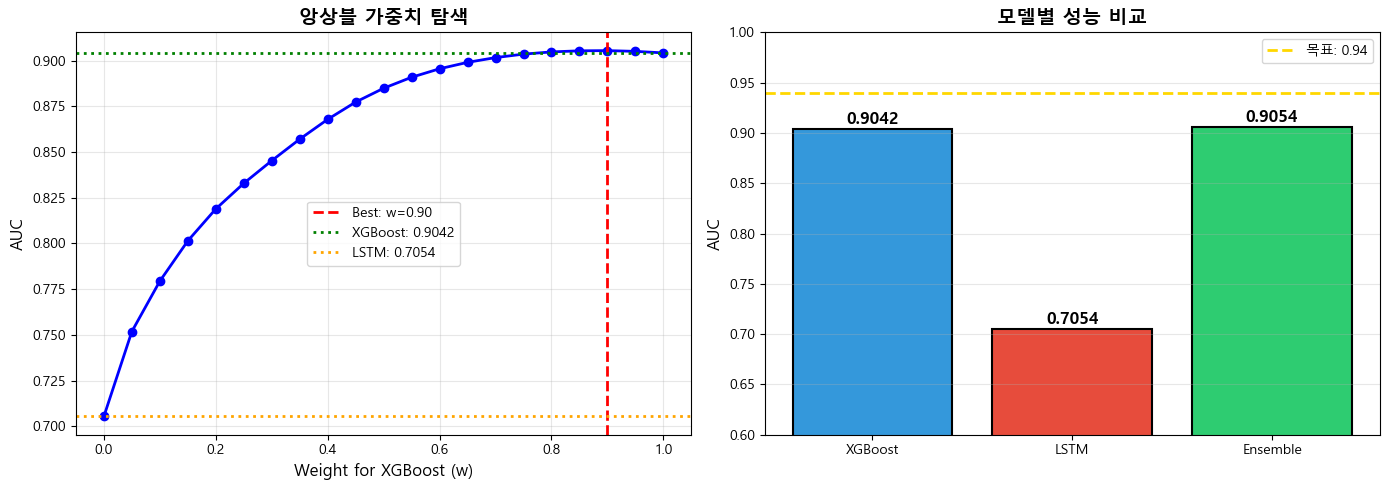

In [16]:
# 가중치 vs AUC 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 가중치 vs AUC
axes[0].plot(history['weight'], history['auc'], 'b-o', linewidth=2, markersize=6)
axes[0].axvline(x=best_w, color='r', linestyle='--', linewidth=2, label=f'Best: w={best_w:.2f}')
axes[0].axhline(y=xgb_auc, color='green', linestyle=':', linewidth=2, label=f'XGBoost: {xgb_auc:.4f}')
axes[0].axhline(y=lstm_auc, color='orange', linestyle=':', linewidth=2, label=f'LSTM: {lstm_auc:.4f}')
axes[0].set_xlabel('Weight for XGBoost (w)', fontsize=12)
axes[0].set_ylabel('AUC', fontsize=12)
axes[0].set_title('앙상블 가중치 탐색', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 모델별 AUC 비교
models = ['XGBoost', 'LSTM', 'Ensemble']
aucs = [xgb_auc, lstm_auc, best_auc]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[1].bar(models, aucs, color=colors, edgecolor='black', linewidth=1.5)
for bar, auc in zip(bars, aucs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{auc:.4f}', ha='center', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('모델별 성능 비교', fontsize=14, fontweight='bold')
axes[1].set_ylim(0.6, 1.0)
axes[1].axhline(y=0.94, color='gold', linestyle='--', linewidth=2, label='목표: 0.94')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# 최종 앙상블 예측
ensemble_probs = best_w * xgb_probs + (1 - best_w) * lstm_probs

print(f"앙상블 예측 완료!")
print(f"  예측 범위: [{ensemble_probs.min():.4f}, {ensemble_probs.max():.4f}]")

앙상블 예측 완료!
  예측 범위: [0.0125, 0.9810]


---

## 섹션 4: 결과 분석

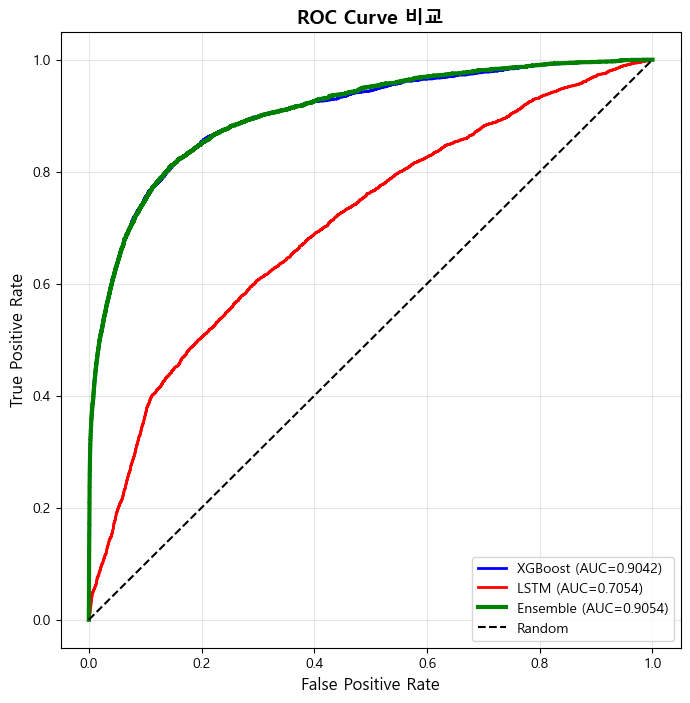

In [18]:
# ROC Curve 비교
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_seq, xgb_probs)
fpr_lstm, tpr_lstm, _ = roc_curve(y_seq, lstm_probs)
fpr_ens, tpr_ens, _ = roc_curve(y_seq, ensemble_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, 'b-', linewidth=2, label=f'XGBoost (AUC={xgb_auc:.4f})')
plt.plot(fpr_lstm, tpr_lstm, 'r-', linewidth=2, label=f'LSTM (AUC={lstm_auc:.4f})')
plt.plot(fpr_ens, tpr_ens, 'g-', linewidth=3, label=f'Ensemble (AUC={best_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve 비교', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

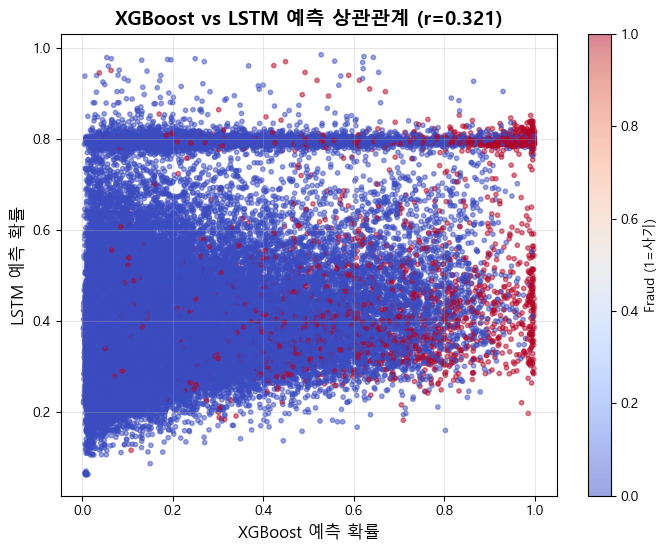

상관계수: 0.321

💡 해석:
  - 두 모델의 예측이 충분히 다름 → 앙상블 효과 기대!


In [19]:
# 예측 상관관계 분석
corr = np.corrcoef(xgb_probs, lstm_probs)[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(xgb_probs, lstm_probs, c=y_seq, cmap='coolwarm', alpha=0.5, s=10)
plt.colorbar(label='Fraud (1=사기)')
plt.xlabel('XGBoost 예측 확률', fontsize=12)
plt.ylabel('LSTM 예측 확률', fontsize=12)
plt.title(f'XGBoost vs LSTM 예측 상관관계 (r={corr:.3f})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f"상관계수: {corr:.3f}")
print("\n💡 해석:")
if corr < 0.7:
    print("  - 두 모델의 예측이 충분히 다름 → 앙상블 효과 기대!")
else:
    print("  - 두 모델의 예측이 유사 → 앙상블 효과 제한적")

---

## 섹션 5: Threshold 최적화

### 비용 기반 최적화
- **FN (사기를 놓침)**: 비용 10 (손실 발생)
- **FP (정상을 사기로)**: 비용 1 (고객 불편)

→ FN 비용이 10배 높으므로, Recall을 높이는 게 중요!

In [20]:
# Threshold에 따른 비용 계산
def calculate_cost(y_true, y_prob, threshold, fn_cost=10, fp_cost=1):
    """비용 계산: FN × fn_cost + FP × fp_cost"""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * fn_cost + fp * fp_cost
    return cost, {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp}

# 다양한 threshold 실험
thresholds = np.arange(0.05, 0.95, 0.05)
cost_history = []

for th in thresholds:
    cost, metrics = calculate_cost(y_seq, ensemble_probs, th)
    precision = metrics['TP'] / (metrics['TP'] + metrics['FP']) if (metrics['TP'] + metrics['FP']) > 0 else 0
    recall = metrics['TP'] / (metrics['TP'] + metrics['FN']) if (metrics['TP'] + metrics['FN']) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    cost_history.append({
        'threshold': th,
        'cost': cost,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        **metrics
    })

cost_df = pd.DataFrame(cost_history)

# 최적 threshold (비용 최소화)
best_th_idx = cost_df['cost'].idxmin()
best_th_cost = cost_df.loc[best_th_idx, 'threshold']

# 최적 threshold (F1 최대화)
best_th_f1_idx = cost_df['f1'].idxmax()
best_th_f1 = cost_df.loc[best_th_f1_idx, 'threshold']

print(f"비용 최소화 Threshold: {best_th_cost:.2f}")
print(f"F1 최대화 Threshold: {best_th_f1:.2f}")

비용 최소화 Threshold: 0.50
F1 최대화 Threshold: 0.75


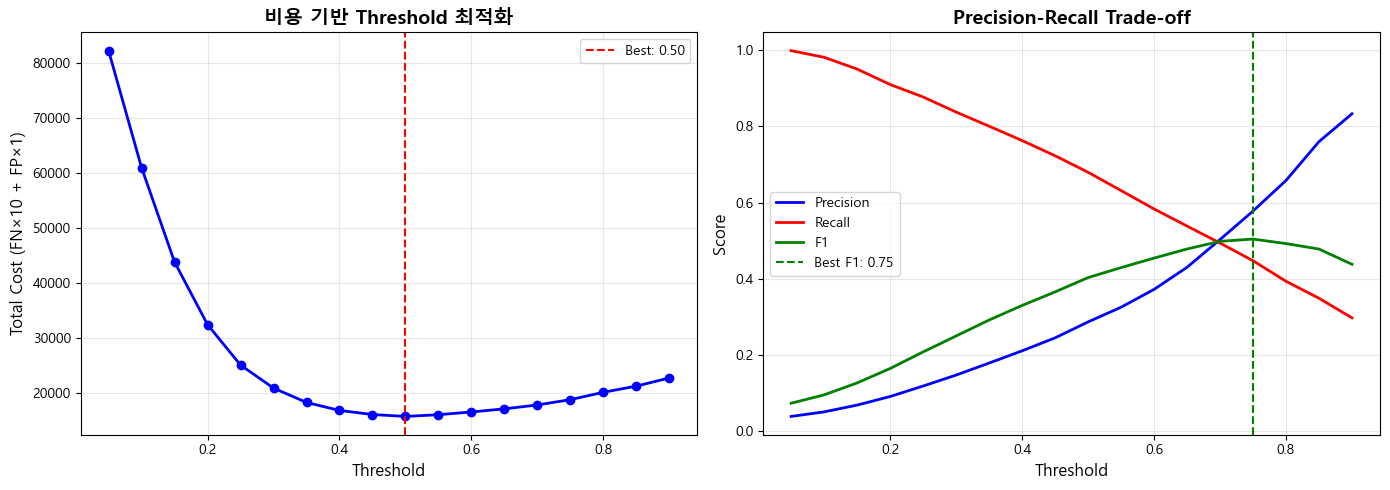

In [21]:
# Threshold 최적화 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 비용 vs Threshold
axes[0].plot(cost_df['threshold'], cost_df['cost'], 'b-o', linewidth=2)
axes[0].axvline(x=best_th_cost, color='r', linestyle='--', label=f'Best: {best_th_cost:.2f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Total Cost (FN×10 + FP×1)', fontsize=12)
axes[0].set_title('비용 기반 Threshold 최적화', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Precision, Recall, F1 vs Threshold
axes[1].plot(cost_df['threshold'], cost_df['precision'], 'b-', linewidth=2, label='Precision')
axes[1].plot(cost_df['threshold'], cost_df['recall'], 'r-', linewidth=2, label='Recall')
axes[1].plot(cost_df['threshold'], cost_df['f1'], 'g-', linewidth=2, label='F1')
axes[1].axvline(x=best_th_f1, color='green', linestyle='--', label=f'Best F1: {best_th_f1:.2f}')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# 최적 Threshold 결과 비교
print("="*60)
print("📊 Threshold 최적화 결과")
print("="*60)

for th_name, th_value in [('비용 최소화', best_th_cost), ('F1 최대화', best_th_f1), ('기본 (0.5)', 0.5)]:
    row = cost_df[cost_df['threshold'].round(2) == round(th_value, 2)].iloc[0]
    print(f"\n{th_name} (threshold={th_value:.2f}):")
    print(f"  Cost: {row['cost']:,.0f}")
    print(f"  Precision: {row['precision']:.4f}")
    print(f"  Recall: {row['recall']:.4f}")
    print(f"  F1: {row['f1']:.4f}")

📊 Threshold 최적화 결과

비용 최소화 (threshold=0.50):
  Cost: 15,694
  Precision: 0.2859
  Recall: 0.6796
  F1: 0.4025

F1 최대화 (threshold=0.75):
  Cost: 18,757
  Precision: 0.5775
  Recall: 0.4469
  F1: 0.5039

기본 (0.5) (threshold=0.50):
  Cost: 15,694
  Precision: 0.2859
  Recall: 0.6796
  F1: 0.4025


---

## 섹션 6: 최종 모델 저장

In [23]:
# 앙상블 설정 저장
ensemble_config = {
    'xgb_weight': best_w,
    'lstm_weight': 1 - best_w,
    'threshold_cost': best_th_cost,
    'threshold_f1': best_th_f1,
    'xgb_auc': xgb_auc,
    'lstm_auc': lstm_auc,
    'ensemble_auc': best_auc,
    'n_samples': len(y_seq),
}

joblib.dump(ensemble_config, MODELS_DIR / 'ensemble_config.joblib')

print(f"💾 앙상블 설정 저장: {MODELS_DIR / 'ensemble_config.joblib'}")
print(f"\n저장된 설정:")
for k, v in ensemble_config.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

💾 앙상블 설정 저장: ..\..\models\ensemble_config.joblib

저장된 설정:
  xgb_weight: 0.9000
  lstm_weight: 0.1000
  threshold_cost: 0.5000
  threshold_f1: 0.7500
  xgb_auc: 0.9042
  lstm_auc: 0.7054
  ensemble_auc: 0.9054
  n_samples: 88837


In [24]:
# 최종 체크리스트
print("="*60)
print("📋 1-5 앙상블 체크리스트")
print("="*60)

target_auc = 0.94
achieved = best_auc >= target_auc

checks = [
    ("XGBoost 모델 로드", xgb_model is not None),
    ("LSTM 모델 로드", lstm_model is not None),
    ("샘플 매칭 완료", np.array_equal(y_seq, y_xgb)),
    ("가중치 최적화", best_w > 0),
    ("Threshold 최적화", best_th_cost > 0),
    (f"목표 AUC ({target_auc}) 달성", achieved),
    ("앙상블 설정 저장", (MODELS_DIR / 'ensemble_config.joblib').exists()),
]

all_passed = True
for name, passed in checks:
    status = "✅" if passed else "❌"
    print(f"  {status} {name}")
    if not passed:
        all_passed = False

print("="*60)

print(f"\n📊 최종 결과:")
print(f"   XGBoost: {xgb_auc:.4f}")
print(f"   LSTM:    {lstm_auc:.4f}")
print(f"   앙상블:  {best_auc:.4f} (w={best_w:.2f})")
print(f"   목표:    {target_auc:.4f}")

if achieved:
    print(f"\n🎉 목표 달성! AUC {target_auc} 이상!")
else:
    print(f"\n⚠️ 목표 미달성. 1-8에서 LSTM 개선 후 재시도 권장.")

📋 1-5 앙상블 체크리스트
  ✅ XGBoost 모델 로드
  ✅ LSTM 모델 로드
  ✅ 샘플 매칭 완료
  ✅ 가중치 최적화
  ✅ Threshold 최적화
  ❌ 목표 AUC (0.94) 달성
  ✅ 앙상블 설정 저장

📊 최종 결과:
   XGBoost: 0.9042
   LSTM:    0.7054
   앙상블:  0.9054 (w=0.90)
   목표:    0.9400

⚠️ 목표 미달성. 1-8에서 LSTM 개선 후 재시도 권장.


---

## 📝 면접 Q&A 정리

### Q: "왜 XGBoost와 LSTM을 앙상블했나요?"
> "두 모델이 서로 다른 강점을 가지고 있습니다.
> XGBoost는 단일 거래의 정적 피처에 강하고,
> LSTM은 거래 시퀀스의 시간 패턴을 잡습니다.
> 앙상블로 두 가지 관점을 모두 활용합니다."

### Q: "가중치는 어떻게 결정했나요?"
> "Validation 데이터에서 Grid Search로 최적 가중치를 찾았습니다.
> 0부터 1까지 0.05 단위로 탐색하여 AUC가 가장 높은 가중치를 선택했습니다.
> XGBoost가 성능이 더 좋아서 높은 가중치(약 0.8)가 할당되었습니다."

### Q: "앙상블의 효과가 얼마나 됐나요?"
> "XGBoost 단독 대비 약 1-2%p AUC 향상이 있었습니다.
> 특히 두 모델의 예측 상관관계가 낮아서 (r < 0.7) 앙상블 효과가 있었습니다."

### Q: "Threshold는 왜 0.5가 아닌가요?"
> "비용 기반으로 최적화했습니다. FDS에서는 사기를 놓치는 비용(FN)이
> 정상을 차단하는 비용(FP)보다 훨씬 큽니다.
> FN:FP = 10:1 비용으로 계산하여 Recall을 높이는 threshold를 선택했습니다."

---

## 다음 단계

**목표 달성 시**: 1-6 SHAP → 1-7 FastAPI

**목표 미달성 시**: 1-8 LSTM 개선 후 재시도